In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from os.path import join
import struct
import matplotlib.pyplot as plt
import datetime

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [7]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

class EMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images_filepath, labels_filepath):
        self.images = read_idx(images_filepath)
        self.labels = read_idx(labels_filepath)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32).reshape(28, 28) / 255.0
        image = torch.from_numpy(image).unsqueeze(0)
        label = int(self.labels[idx])
        return image, label

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 47)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [9]:
input_path = 'dataset'
training_images_filepath = join(input_path, 'emnist-balanced-train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'emnist-balanced-train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 'emnist-balanced-test-images-idx3-ubyte')
test_labels_filepath = join(input_path, 'emnist-balanced-test-labels-idx1-ubyte')

train_dataset = EMNISTDataset(training_images_filepath, training_labels_filepath)
test_dataset = EMNISTDataset(test_images_filepath, test_labels_filepath)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [10]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
writer = SummaryWriter('runs/emnist_experiment')

In [12]:
def train(epochs):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
                writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)

        test(epoch)

In [13]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/test', accuracy, epoch)

In [14]:
train(epochs=5)

writer.close()

Train Epoch: 0 [0/112800 (0%)]	Loss: 3.848723
Train Epoch: 0 [6400/112800 (6%)]	Loss: 2.984640
Train Epoch: 0 [12800/112800 (11%)]	Loss: 1.524791
Train Epoch: 0 [19200/112800 (17%)]	Loss: 1.210220
Train Epoch: 0 [25600/112800 (23%)]	Loss: 0.925403
Train Epoch: 0 [32000/112800 (28%)]	Loss: 0.741917
Train Epoch: 0 [38400/112800 (34%)]	Loss: 0.787487
Train Epoch: 0 [44800/112800 (40%)]	Loss: 0.977385
Train Epoch: 0 [51200/112800 (45%)]	Loss: 0.650074
Train Epoch: 0 [57600/112800 (51%)]	Loss: 0.841392
Train Epoch: 0 [64000/112800 (57%)]	Loss: 0.676532
Train Epoch: 0 [70400/112800 (62%)]	Loss: 0.531027
Train Epoch: 0 [76800/112800 (68%)]	Loss: 0.558533
Train Epoch: 0 [83200/112800 (74%)]	Loss: 0.821048
Train Epoch: 0 [89600/112800 (79%)]	Loss: 0.744429
Train Epoch: 0 [96000/112800 (85%)]	Loss: 0.538622
Train Epoch: 0 [102400/112800 (91%)]	Loss: 0.725021
Train Epoch: 0 [108800/112800 (96%)]	Loss: 0.662555

Test set: Average loss: 0.0005, Accuracy: 15891/18800 (84.53%)

Train Epoch: 1 [0/1128

In [15]:
def visualize_predictions(model, dataset, num_images=5):
    class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[np.random.randint(len(dataset))]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            pred = output.argmax(dim=1).item()
        
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Pred: {class_mapping[pred]}, True: {class_mapping[label]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

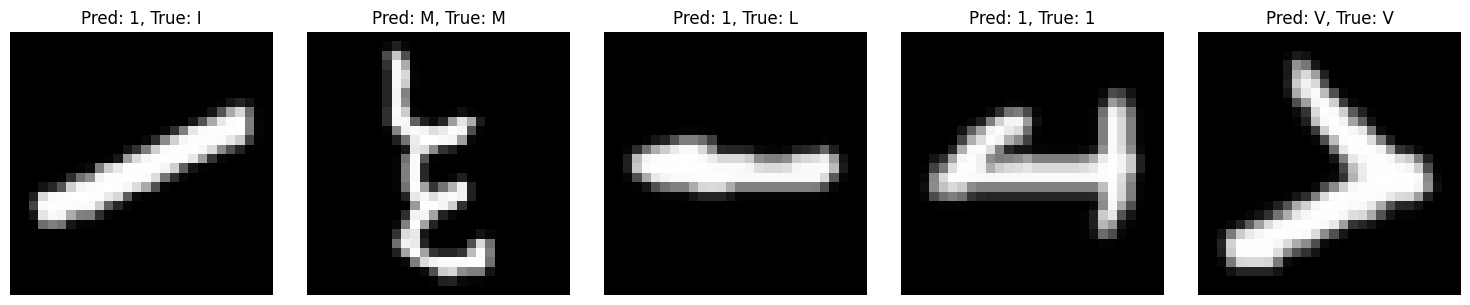

In [16]:
visualize_predictions(model, test_dataset)

In [23]:
models_dir = 'models'
model_name = f'emnist_model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pth'


torch.save(model.state_dict(), join(models_dir, model_name))
print(f"Model saved to '{join(models_dir, model_name)}'")

Model saved to 'models/emnist_model_2024-07-02_19-44-52.pth'
